# Geospatial Matching Optimization

This project is designed to showcase how to improve the speed of a polygon matching procedure. There are two main areas that could benefit from taking a "geospatial-native" approach:

1. Data encoding, fetching, and storage
2. Searching for Overlaps

We will generate synthetic polygon data and use both a non-geospatial-native and geospatial-native approach, comparing execution time for both to see how they differ.

## Imports

In [629]:
import geopandas as gpd
import pandas as pd
import shapely
import h3
import time
import helpers as h
import parallel_processing_fixed as p
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from shapely.wkt import dumps, loads
from pathlib import Path
import multiprocessing as mp
import datetime
import psycopg2
from psycopg2 import sql, extras
import random

# ensure helpers is loaded correctly
import importlib
importlib.reload(h)
importlib.reload(p)

<module 'parallel_processing_fixed' from '/Users/sra/files/projects/matching_optimization/parallel_processing_fixed.py'>

## Retrieve Generated Test Data

In [ ]:
# prev_month_blobs = gpd.read_parquet('data/prev_month_blobs_5k.parquet')
# curr_month_blobs = gpd.read_parquet('data/curr_month_blobs_5k.parquet')
prev_month_blobs = gpd.read_parquet('data/prev_month_blobs_10k.parquet')
curr_month_blobs = gpd.read_parquet('data/curr_month_blobs_10k.parquet')

In [631]:
# save to geojson to confirm in QGIS
blobs_geojson = Path('data/prev_month_blobs.geojson')
if not blobs_geojson.is_file():
    prev_month_blobs.to_file('data/prev_month_blobs.geojson')
    curr_month_blobs.to_file('data/curr_month_blobs.geojson')

In [632]:
prev_month_blobs.head()

,id,geohash,geometry
0,ca183bad-11b9-41c2-aacc-0e47998c1aae,dhy170,"POLYGON ((-81.43569 26.90748, -81.41019 26.907..."
1,7baf227b-44dd-4f83-8358-86ead1340216,dhyhbg,"POLYGON ((-81.54525 27.56416, -81.49408 27.564..."
2,21f52cff-6393-4af5-9788-a4cd11464392,dhyju4,"POLYGON ((-81.40864 27.69120, -81.34767 27.691..."
3,e33990b4-44d4-4144-8255-07baf44d094f,dhvz1t,"POLYGON ((-81.85074 27.95994, -81.83749 27.959..."
4,6e9fc597-f945-437e-892b-271e4c835b89,dhvrt6,"POLYGON ((-82.41521 28.01677, -82.35104 28.016..."


In [633]:
curr_month_blobs.head()

,id,geohash,geometry
0,a7e1b696-de3f-4b5b-8d39-27d58dbc0dc6,dhwd1u,"POLYGON ((-80.79683 25.65341, -80.75115 25.653..."
1,7a2e0ccc-8fc4-4bb2-802f-aaf55ce772cb,dhwd3b,"POLYGON ((-80.81789 25.66950, -80.74523 25.669..."
2,578807dd-17bd-4823-b9e8-4f1a5b6c5c3a,dhwd34,"POLYGON ((-80.82699 25.70919, -80.79109 25.709..."
3,25d8428a-7f7f-481b-8cef-2d751b28cd1e,dhwkgu,"POLYGON ((-81.06182 26.14503, -81.02551 26.145..."
4,95bae651-4998-46b8-a8e2-e3e84875bae2,dhwwhk,"POLYGON ((-80.67751 26.35388, -80.66519 26.353..."


We have to redefine the order of the columns:

In [634]:
prev_month_blobs = prev_month_blobs[['geometry', 'id', 'geohash']]
prev_month_blobs.head()

,geometry,id,geohash
0,"POLYGON ((-81.43569 26.90748, -81.41019 26.907...",ca183bad-11b9-41c2-aacc-0e47998c1aae,dhy170
1,"POLYGON ((-81.54525 27.56416, -81.49408 27.564...",7baf227b-44dd-4f83-8358-86ead1340216,dhyhbg
2,"POLYGON ((-81.40864 27.69120, -81.34767 27.691...",21f52cff-6393-4af5-9788-a4cd11464392,dhyju4
3,"POLYGON ((-81.85074 27.95994, -81.83749 27.959...",e33990b4-44d4-4144-8255-07baf44d094f,dhvz1t
4,"POLYGON ((-82.41521 28.01677, -82.35104 28.016...",6e9fc597-f945-437e-892b-271e4c835b89,dhvrt6


In [635]:
curr_month_blobs = curr_month_blobs[['geometry', 'id', 'geohash']]
curr_month_blobs.head()

,geometry,id,geohash
0,"POLYGON ((-80.79683 25.65341, -80.75115 25.653...",a7e1b696-de3f-4b5b-8d39-27d58dbc0dc6,dhwd1u
1,"POLYGON ((-80.81789 25.66950, -80.74523 25.669...",7a2e0ccc-8fc4-4bb2-802f-aaf55ce772cb,dhwd3b
2,"POLYGON ((-80.82699 25.70919, -80.79109 25.709...",578807dd-17bd-4823-b9e8-4f1a5b6c5c3a,dhwd34
3,"POLYGON ((-81.06182 26.14503, -81.02551 26.145...",25d8428a-7f7f-481b-8cef-2d751b28cd1e,dhwkgu
4,"POLYGON ((-80.67751 26.35388, -80.66519 26.353...",95bae651-4998-46b8-a8e2-e3e84875bae2,dhwwhk


In [636]:
# overwrite them with correct column order
# make data folder
Path('data/').mkdir(exist_ok=True)

# save as geoparquet
prev_month_blobs.to_parquet('data/prev_month_blobs.parquet')
curr_month_blobs.to_parquet('data/curr_month_blobs.parquet')

In [637]:
# range_ = 10000

# fig, ax = plt.subplots(figsize=(5, 5))
# prev_month_blobs.iloc[0:range_].plot(ax=ax)
# ax.set_title(f'Viewing the first {range_} blobs')
# plt.tight_layout()

# plt.show()

## 1. Non-optimized process

### 1.1. Data encoding, storage, and fetching

We will use PostgreSQL and string storage for geographic information.

#### Make copy of polygon layer and convert to non-geospatial-native string (WKT) datatype

In [638]:
# copy the gdfs
prev_month_blobs_wkt = prev_month_blobs.copy()
curr_month_blobs_wkt = curr_month_blobs.copy()

In [639]:
# Convert WKT versions to strings
dfs_to_convert = [prev_month_blobs_wkt, curr_month_blobs_wkt]
prev_month_blobs_wkt, curr_month_blobs_wkt = [h.convert_col_to_string(df) for df in dfs_to_convert]

# Check result
print(prev_month_blobs_wkt.head())

Function `convert_col_to_string` executed in 0.0271 sec, CPU: 24.00%, Memory: 0.23MB
Function `convert_col_to_string` executed in 0.0241 sec, CPU: 0.00%, Memory: 0.14MB
                                            geometry  \
0  POLYGON ((-81.435694 26.907481, -81.410188 26....   
1  POLYGON ((-81.545254 27.564155, -81.494076 27....   
2  POLYGON ((-81.408638 27.691199, -81.347671 27....   
3  POLYGON ((-81.850736 27.95994, -81.837487 27.9...   
4  POLYGON ((-82.415205 28.016766, -82.351039 28....   

                                     id geohash  
0  ca183bad-11b9-41c2-aacc-0e47998c1aae  dhy170  
1  7baf227b-44dd-4f83-8358-86ead1340216  dhyhbg  
2  21f52cff-6393-4af5-9788-a4cd11464392  dhyju4  
3  e33990b4-44d4-4144-8255-07baf44d094f  dhvz1t  
4  6e9fc597-f945-437e-892b-271e4c835b89  dhvrt6  


/Users/sra/files/projects/matching_optimization/helpers.py:214: UserWarning: Geometry column does not contain geometry.
  df[col] = df[col].apply(lambda geom: to_wkt(geom) if isinstance(geom, BaseGeometry) else str(geom))
/Users/sra/files/projects/matching_optimization/helpers.py:214: UserWarning: Geometry column does not contain geometry.
  df[col] = df[col].apply(lambda geom: to_wkt(geom) if isinstance(geom, BaseGeometry) else str(geom))


#### Save in PostgreSQL database

This is a simple version of what a "non-geospatial-native" data ingestion pipeline may look like, with the primary example being that the polygons are stored as strings, not in a spatial-friendly datatype.

In [640]:
# Convert to tuples
prev_month_blobs_wkt = h.df_itertuple(prev_month_blobs_wkt)
curr_month_blobs_wkt = h.df_itertuple(curr_month_blobs_wkt)

Function `df_itertuple` executed in 0.0019 sec, CPU: 0.00%, Memory: 0.09MB
Function `df_itertuple` executed in 0.0016 sec, CPU: 0.00%, Memory: 0.00MB


Create PostgreSQL database if it doesn't exist already. We will be using the default settings. If they need to be adjusted, refer to [`helpers.py`](helpers.py).

In [641]:
h.create_pg_db()

Database blob_matching already exists.
Function `create_pg_db` executed in 0.0315 sec, CPU: 0.00%, Memory: 0.00MB


Create and insert into tables:

In [642]:
prev_month_blobs.head(1)

,geometry,id,geohash
0,"POLYGON ((-81.43569 26.90748, -81.41019 26.907...",ca183bad-11b9-41c2-aacc-0e47998c1aae,dhy170


In [643]:
prev_month_blobs_wkt[0]

('POLYGON ((-81.435694 26.907481, -81.410188 26.907481, -81.410188 26.972838, -81.435694 26.972838, -81.435694 26.907481))',
 'ca183bad-11b9-41c2-aacc-0e47998c1aae',
 'dhy170')

In [644]:
h.create_pg_table(table_name='prev_blobs_wkt', data=prev_month_blobs_wkt, truncate=True)
h.create_pg_table(table_name='curr_blobs_wkt', data=curr_month_blobs_wkt, truncate=True)

Table prev_blobs_wkt truncated.
Inserted 5000 records into prev_blobs_wkt.
Function `create_pg_table` executed in 0.2075 sec, CPU: 0.00%, Memory: 0.00MB
Table curr_blobs_wkt truncated.
Inserted 5000 records into curr_blobs_wkt.
Function `create_pg_table` executed in 0.1892 sec, CPU: 0.00%, Memory: 0.00MB


Retrieve data as GeoDataFrames to confirm that it worked:

In [645]:
df_prev = h.retrieve_pg_table(table_name='prev_blobs_wkt')
df_curr = h.retrieve_pg_table(table_name='curr_blobs_wkt')

Retrieved 5000 records from prev_blobs_wkt.
Function `retrieve_pg_table` executed in 0.0238 sec, CPU: 0.00%, Memory: 0.00MB
Retrieved 5000 records from curr_blobs_wkt.
Function `retrieve_pg_table` executed in 0.0214 sec, CPU: 0.00%, Memory: 0.00MB


Compare the tables before and after for a sanity check:

In [646]:
df_prev.head()

,geometry,id,geohash
0,"POLYGON ((-81.435694 26.907481, -81.410188 26....",ca183bad-11b9-41c2-aacc-0e47998c1aae,dhy170
1,"POLYGON ((-81.545254 27.564155, -81.494076 27....",7baf227b-44dd-4f83-8358-86ead1340216,dhyhbg
2,"POLYGON ((-81.408638 27.691199, -81.347671 27....",21f52cff-6393-4af5-9788-a4cd11464392,dhyju4
3,"POLYGON ((-81.850736 27.95994, -81.837487 27.9...",e33990b4-44d4-4144-8255-07baf44d094f,dhvz1t
4,"POLYGON ((-82.415205 28.016766, -82.351039 28....",6e9fc597-f945-437e-892b-271e4c835b89,dhvrt6


In [647]:
prev_month_blobs.head()

,geometry,id,geohash
0,"POLYGON ((-81.43569 26.90748, -81.41019 26.907...",ca183bad-11b9-41c2-aacc-0e47998c1aae,dhy170
1,"POLYGON ((-81.54525 27.56416, -81.49408 27.564...",7baf227b-44dd-4f83-8358-86ead1340216,dhyhbg
2,"POLYGON ((-81.40864 27.69120, -81.34767 27.691...",21f52cff-6393-4af5-9788-a4cd11464392,dhyju4
3,"POLYGON ((-81.85074 27.95994, -81.83749 27.959...",e33990b4-44d4-4144-8255-07baf44d094f,dhvz1t
4,"POLYGON ((-82.41521 28.01677, -82.35104 28.016...",6e9fc597-f945-437e-892b-271e4c835b89,dhvrt6


Confirm that the original blob dfs and the retrieved dfs are the same length:

In [648]:
def round_geometry(geom, precision=6):
    """Round all coordinates of a geometry to a given precision."""
    return shapely.wkt.loads(shapely.wkt.dumps(geom, rounding_precision=precision))

# Convert both to sets of rounded WKT strings
set_prev_month_blobs = set(prev_month_blobs['geometry'].apply(lambda g: round_geometry(g, precision=6).wkt))
set_df_prev = set(df_prev['geometry'].apply(lambda g: round_geometry(g, precision=6).wkt))

# Find common, missing, and extra geometries
common_geometries = set_prev_month_blobs & set_df_prev
missing_from_retrieved = set_prev_month_blobs - set_df_prev
extra_in_retrieved = set_df_prev - set_prev_month_blobs

# Print summary
print(f"Number of matching geometries: {len(common_geometries)}")
print(f"Missing geometries in retrieved table: {len(missing_from_retrieved)}")
print(f"Extra geometries in retrieved table: {len(extra_in_retrieved)}")

# Show an example missing/extra geometry for debugging
if missing_from_retrieved:
    print("Example missing record:", next(iter(missing_from_retrieved)))

if extra_in_retrieved:
    print("Example extra record:", next(iter(extra_in_retrieved)))

Number of matching geometries: 5000
Missing geometries in retrieved table: 0
Extra geometries in retrieved table: 0


It worked! Now we can proceed to "matching" any "previous" polygons that overlap with the "current" polygons.

### 1.2. Searching for Overlaps

We will search for overlapping polygons using GeoPandas.

In [649]:
start = datetime.datetime.now()
print('Start time:', start)
postgresql_details = h.pg_details()
p.run_parallel_matching_with_grid(
    table_prev='prev_blobs_wkt', 
    table_curr='curr_blobs_wkt', 
    output_table='matched_results', 
    postgresql_details=postgresql_details, 
    db_name='blob_matching', 
    num_workers=4,
    verbose=2
    )
end = datetime.datetime.now()
print('End time:', end)
print('Total time:', end - start)

Start time: 2025-03-04 00:46:03.256928
Table matched_results created successfully.
Total partitions to process: 4
Total matches found: 372
Logging listener has shut down.
Function `run_parallel_matching_with_grid` executed in 1.8024 sec, CPU: 56.70%, Memory: 126.56MB
End time: 2025-03-04 00:46:05.060131
Total time: 0:00:01.803203


In [650]:
# # testing logging for matching_geometries
# df_prev = h._retrieve_pg_table(postgresql_details, 'blob_matching', "prev_blobs_wkt")#, log_enabled=True)
# df_curr = h._retrieve_pg_table(postgresql_details, 'blob_matching', "curr_blobs_wkt")#, log_enabled=True)

# # Use a small subset for testing
# # df_prev_sample = df_prev.sample(10, random_state=42)
# # df_curr_sample = df_curr.sample(10, random_state=42)

# # h.match_geometries(df_prev_sample, df_curr_sample)  # Check if this logs matches
# h.match_geometries(df_prev, df_curr)  # Check if this logs matches

Confirm that the postgres matching table has the same number of matches:

In [651]:
count = h.retrieve_pg_table(table_name='matched_results', count=True)

Total matches in matched_results: 372
Function `retrieve_pg_table` executed in 0.0056 sec, CPU: 22.30%, Memory: 0.00MB


In [652]:
# save log files as .parquet
h.convert_logs_to_parquet(csv_path=Path('logs/timing_results.csv'),
                          log_path=Path('logs/timing.log'))

Converted logs/timing_results.csv to logs/timing_results.parquet
Converted logs/timing.log to logs/timing_log.parquet


View the overall polygon layers and then some subplots with locations of the matched polygons:

Retrieved 5000 records from prev_blobs_wkt.
Function `retrieve_pg_table` executed in 0.0312 sec, CPU: 9.20%, Memory: 0.14MB
Retrieved 5000 records from curr_blobs_wkt.
Function `retrieve_pg_table` executed in 0.0300 sec, CPU: 16.70%, Memory: 7.94MB
Retrieved 372 records from matched_results.
Sampled columns: Index(['prev_id', 'curr_id', 'geometry_prev', 'id_prev', 'geohash_prev',
       'geometry_curr', 'id_curr', 'geohash_curr'],
      dtype='object')
Overlapping_a columns: Index(['geometry', 'id', 'geohash'], dtype='object')
Overlapping_b columns: Index(['geometry', 'id', 'geohash'], dtype='object')
sample_a columns: Index(['geometry_prev', 'id_prev', 'geohash_prev'], dtype='object')
sample_b columns: Index(['geometry_curr', 'id_curr', 'geohash_curr'], dtype='object')


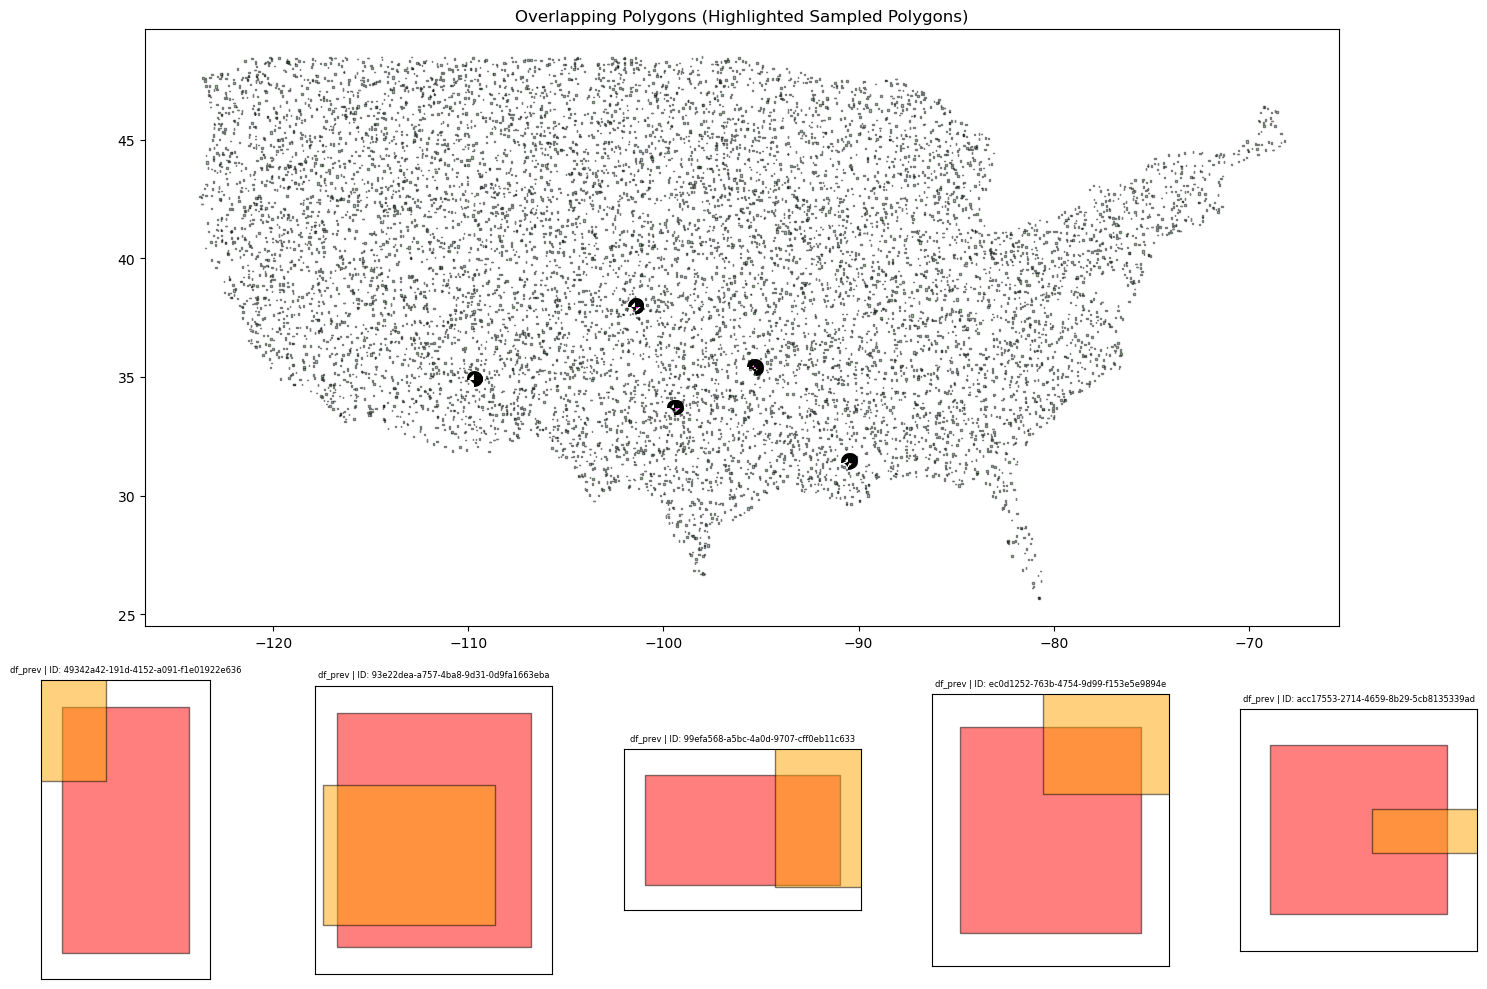

In [ ]:
# --- Retrieve Data from PostgreSQL ---
df_prev = h.retrieve_pg_table(table_name='prev_blobs_wkt')
df_curr = h.retrieve_pg_table(table_name='curr_blobs_wkt')

# Ensure they are GeoDataFrames
df_prev = gpd.GeoDataFrame(df_prev, geometry='geometry', crs="EPSG:4326")
df_curr = gpd.GeoDataFrame(df_curr, geometry='geometry', crs="EPSG:4326")

# Retrieve matches table
table_name = 'matched_results'
postgresql_details['dbname'] = 'blob_matching'
conn = psycopg2.connect(**postgresql_details)
cur = conn.cursor()
cur.execute(f"SELECT prev_id, curr_id FROM {table_name};")
rows = cur.fetchall()
cur.close()
conn.close()

# Convert matches to DataFrame
matches = pd.DataFrame(rows, columns=["prev_id", "curr_id"])
print(f"Retrieved {len(matches)} records from {table_name}.")

# Find matching polygons
overlapping_a = df_prev[df_prev['id'].isin(matches['prev_id'])]
overlapping_b = df_curr[df_curr['id'].isin(matches['curr_id'])]

# --- Sample Overlapping Polygons ---
# Merge to ensure exact pairs before sampling
merged = matches.merge(overlapping_a, left_on="prev_id", right_on="id").merge(
    overlapping_b, left_on="curr_id", right_on="id", suffixes=("_prev", "_curr")
)

# Sample up to 5 matched pairs
sampled = merged.sample(n=min(5, len(merged)), random_state=42)

# debug
print("Sampled columns:", sampled.columns)
print("Overlapping_a columns:", overlapping_a.columns)
print("Overlapping_b columns:", overlapping_b.columns)

# Extract individual DataFrames
sample_a = sampled[[col + "_prev" for col in overlapping_a.columns]]
sample_b = sampled[[col + "_curr" for col in overlapping_b.columns]]

# debug
print("sample_a columns:", sample_a.columns)
print("sample_b columns:", sample_b.columns)

# --- Define Figure Layout ---
fig = plt.figure(figsize=(15, 10))

# Main plot (2x height), subplots (1x height)
gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1]) 

# --- Main Plot: Initial Polygons ---
ax_main = fig.add_subplot(gs[0])
df_prev.plot(ax=ax_main, color='lightblue', edgecolor='black', alpha=0.5, label="Previous", zorder=1)
df_curr.plot(ax=ax_main, color='lightgreen', edgecolor='black', alpha=0.5, label="Current", zorder=1)

# Highlight sampled polygons (plot the correct 'geometry' column directly)
sample_a.set_geometry('geometry_prev').plot(ax=ax_main, color='none', edgecolor='yellow', linewidth=1, linestyle='dashed', zorder=3)
sample_b.set_geometry('geometry_curr').plot(ax=ax_main, color='none', edgecolor='magenta', linewidth=1, linestyle='dashed', zorder=3)

# Emphasize selected polygons (plot the correct 'geometry' column directly)
sample_a.set_geometry('geometry_prev').plot(ax=ax_main, color='none', edgecolor='black', linewidth=10, linestyle='solid', zorder=4)
sample_b.set_geometry('geometry_curr').plot(ax=ax_main, color='none', edgecolor='black', linewidth=10, linestyle='solid', zorder=4)

ax_main.set_title("Overlapping Polygons (Highlighted Sampled Polygons)")

# --- Dynamic Subplots (Centered Below) ---
gs_subplots = gridspec.GridSpecFromSubplotSpec(1, sample_size, subplot_spec=gs[1], wspace=0.3)

for i, (idx, row) in enumerate(sample_a.iterrows()):
    ax = fig.add_subplot(gs_subplots[0, i])
    subset_a = sample_a.iloc[[i]]
    subset_b = sample_b.iloc[[i]]

    # Set geometry and plot explicitly by accessing the geometry
    subset_a = subset_a.set_geometry('geometry_prev')  # Ensure geometry is set
    subset_b = subset_b.set_geometry('geometry_curr')  # Ensure geometry is set

    # Plot the geometries explicitly
    subset_a.plot(ax=ax, color="red", edgecolor="black", alpha=0.5)
    subset_b.plot(ax=ax, color="orange", edgecolor="black", alpha=0.5)

    # Adjust zoom
    bounds = subset_a.geometry.bounds.values[0]  # Explicitly use .geometry for bounds
    buffer = 0.01
    ax.set_xlim(bounds[0] - buffer, bounds[2] + buffer)
    ax.set_ylim(bounds[1] - buffer, bounds[3] + buffer)

    # Titles & Aesthetics
    ax.set_title(f"df_prev | ID: {row['id_prev']}", fontsize=6)  # Use the appropriate ID column
    ax.set_xticks([])  
    ax.set_yticks([])

# Adjust layout and show
plt.tight_layout()

# plt.savefig('figs/overlapping_polygons_map_5k.pdf', bbox_inches='tight')
# plt.savefig('figs/overlapping_polygons_map_5k.png', bbox_inches='tight')

plt.savefig('figs/overlapping_polygons_map_10000.pdf', bbox_inches='tight')
plt.savefig('figs/overlapping_polygons_map_10000.png', bbox_inches='tight')

plt.show()

Retrieved 5000 records from prev_blobs_wkt.
Function `retrieve_pg_table` executed in 0.0776 sec, CPU: 33.70%, Memory: 11.52MB
Retrieved 5000 records from curr_blobs_wkt.
Function `retrieve_pg_table` executed in 0.0399 sec, CPU: 0.00%, Memory: 5.89MB
Retrieved 428 records from matched_results.


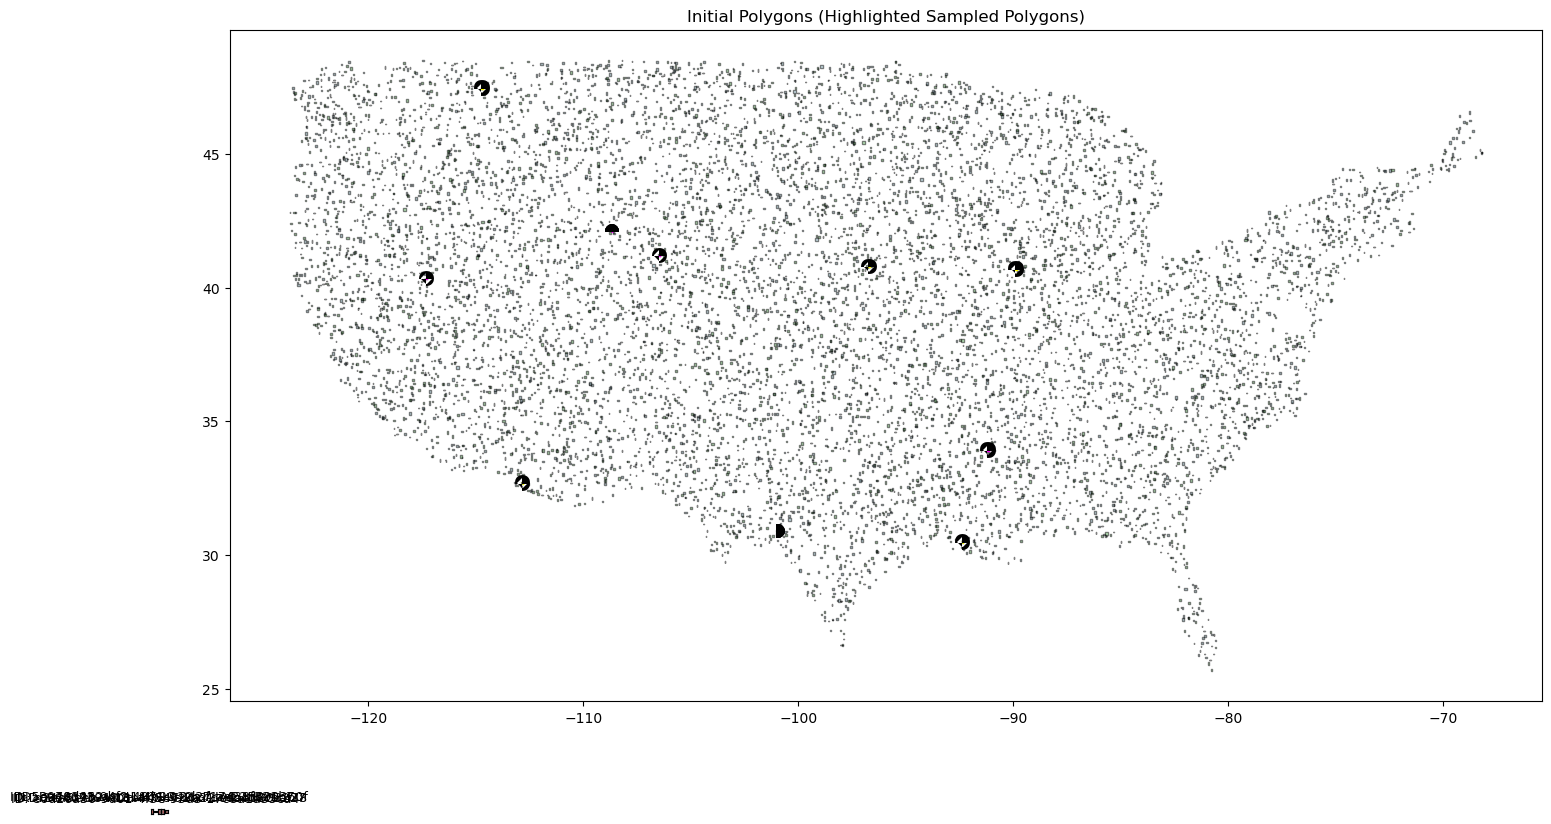

In [ ]:
# --- Retrieve Data from PostgreSQL ---
df_prev = h.retrieve_pg_table(table_name='prev_blobs_wkt')
df_curr = h.retrieve_pg_table(table_name='curr_blobs_wkt')

# Ensure they are GeoDataFrames
df_prev = gpd.GeoDataFrame(df_prev, geometry='geometry', crs="EPSG:4326")
df_curr = gpd.GeoDataFrame(df_curr, geometry='geometry', crs="EPSG:4326")

# Retrieve matches table
table_name = 'matched_results'
postgresql_details['dbname'] = 'blob_matching'
conn = psycopg2.connect(**postgresql_details)
cur = conn.cursor()
cur.execute(f"SELECT prev_id, curr_id FROM {table_name};")
rows = cur.fetchall()
cur.close()
conn.close()

# Convert matches to DataFrame
matches = pd.DataFrame(rows, columns=["prev_id", "curr_id"])
print(f"Retrieved {len(matches)} records from {table_name}.")

# Find matching polygons
overlapping_a = df_prev[df_prev['id'].isin(matches['prev_id'])]
overlapping_b = df_curr[df_curr['id'].isin(matches['curr_id'])]

# --- Sample Overlapping Polygons ---
sample_size = min(len(matches), len(overlapping_a))  # Limit to 5
if sample_size > 0:
    sample_indices = random.sample(range(len(overlapping_a)), sample_size)
    # Sample up to 5 elements from each DataFrame (if they have enough rows)
    sample_a = overlapping_a.sample(n=min(5, len(overlapping_a)), random_state=42)
    sample_b = overlapping_b.sample(n=min(5, len(overlapping_b)), random_state=42)
    # sample_a = overlapping_a.iloc[sample_indices]
    # sample_b = overlapping_b.iloc[sample_indices]
else:
    sample_a, sample_b = gpd.GeoDataFrame(), gpd.GeoDataFrame()

# --- Define Figure Layout ---
fig = plt.figure(figsize=(15, 10))

# Main plot (2x height), subplots (1x height)
gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1]) 

# --- Main Plot: Initial Polygons ---
ax_main = fig.add_subplot(gs[0])
df_prev.plot(ax=ax_main, color='lightblue', edgecolor='black', alpha=0.5, label="Previous", zorder=1)
df_curr.plot(ax=ax_main, color='lightgreen', edgecolor='black', alpha=0.5, label="Current", zorder=1)

# Highlight sampled polygons
sample_a.plot(ax=ax_main, color='none', edgecolor='yellow', linewidth=1, linestyle='dashed', zorder=3)
sample_b.plot(ax=ax_main, color='none', edgecolor='magenta', linewidth=1, linestyle='dashed', zorder=3)

# Emphasize selected polygons
sample_a.plot(ax=ax_main, color='none', edgecolor='black', linewidth=10, linestyle='solid', zorder=4)
sample_b.plot(ax=ax_main, color='none', edgecolor='black', linewidth=10, linestyle='solid', zorder=4)

ax_main.set_title("Initial Polygons (Highlighted Sampled Polygons)")

# --- Dynamic Subplots (Centered Below) ---
gs_subplots = gridspec.GridSpecFromSubplotSpec(1, sample_size, subplot_spec=gs[1], wspace=0.3)

for i, (idx, row) in enumerate(sample_a.iterrows()):
    ax = fig.add_subplot(gs_subplots[0, i])
    subset_a = sample_a.iloc[[i]]
    subset_b = sample_b.iloc[[i]]

    subset_a.plot(ax=ax, color="red", edgecolor="black", alpha=0.5)
    subset_b.plot(ax=ax, color="orange", edgecolor="black", alpha=0.5)

    # Adjust zoom
    bounds = subset_a.geometry.bounds.values[0]
    buffer = 0.01
    ax.set_xlim(bounds[0] - buffer, bounds[2] + buffer)
    ax.set_ylim(bounds[1] - buffer, bounds[3] + buffer)

    # Titles & Aesthetics
    ax.set_title(f"ID: {row['id']}", fontsize=9)
    ax.set_xticks([])  
    ax.set_yticks([])

# Adjust layout and show
plt.tight_layout()
plt.show()

Retrieved 5000 records from prev_blobs_wkt.
Function `retrieve_pg_table` executed in 0.0714 sec, CPU: 17.60%, Memory: 64.86MB
Retrieved 5000 records from curr_blobs_wkt.
Function `retrieve_pg_table` executed in 0.0385 sec, CPU: 68.70%, Memory: 1.33MB
Retrieved 428 records from matched_results.
Log queue closed unexpectedly.
Logging listener has shut down.


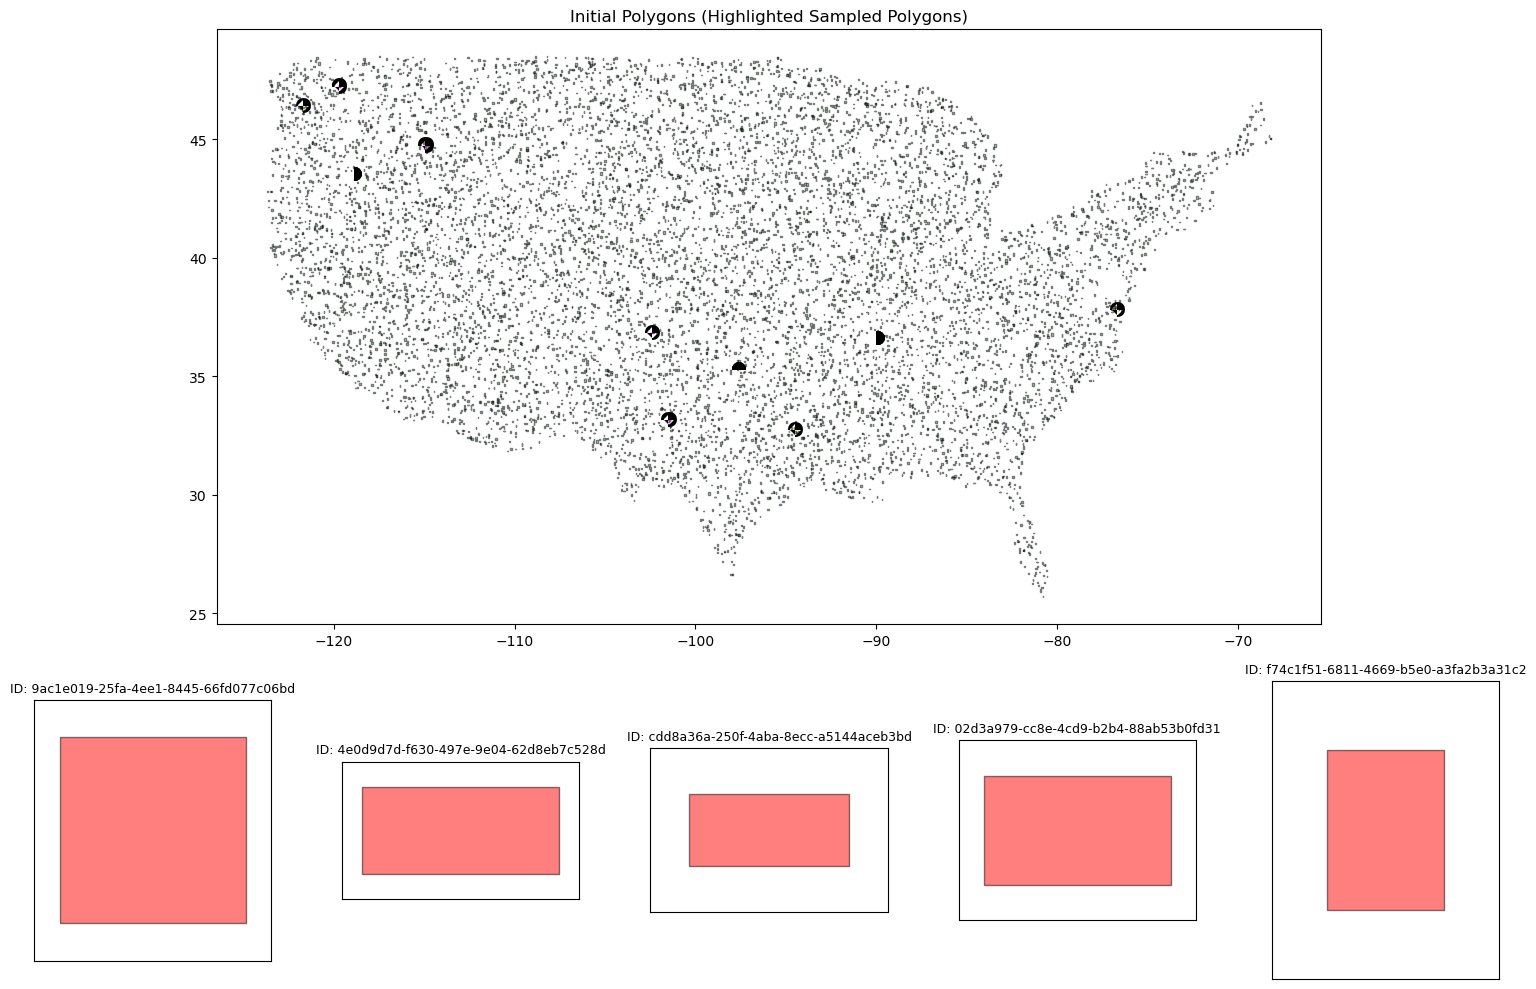

In [510]:
# --- Retrieve Data from PostgreSQL ---
df_prev = h.retrieve_pg_table(table_name='prev_blobs_wkt')
df_curr = h.retrieve_pg_table(table_name='curr_blobs_wkt')

# Ensure they are GeoDataFrames
df_prev = gpd.GeoDataFrame(df_prev, geometry='geometry', crs="EPSG:4326")
df_curr = gpd.GeoDataFrame(df_curr, geometry='geometry', crs="EPSG:4326")

# Retrieve matches table
table_name = 'matched_results'
postgresql_details['dbname'] = 'blob_matching'
conn = psycopg2.connect(**postgresql_details)
cur = conn.cursor()
cur.execute(f"SELECT prev_id, curr_id FROM {table_name};")
rows = cur.fetchall()
cur.close()
conn.close()

# Convert matches to DataFrame
matches = pd.DataFrame(rows, columns=["prev_id", "curr_id"])
print(f"Retrieved {len(matches)} records from {table_name}.")

# Find matching polygons
overlapping_a = df_prev[df_prev['id'].isin(matches['prev_id'])]
overlapping_b = df_curr[df_curr['id'].isin(matches['curr_id'])]

# --- Sample Overlapping Polygons ---
sample_size = min(len(matches), 5) #len(overlapping_a))  # Limit to 5
if sample_size > 0:
    sample_indices = random.sample(range(len(overlapping_a)), sample_size)
    sample_a = overlapping_a.iloc[sample_indices]
    sample_b = overlapping_b.iloc[sample_indices]
else:
    sample_a, sample_b = gpd.GeoDataFrame(), gpd.GeoDataFrame()

# --- Define Figure Layout ---
fig = plt.figure(figsize=(15, 10))

# Main plot (2x height), subplots (1x height)
gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1]) 

# --- Main Plot: Initial Polygons ---
ax_main = fig.add_subplot(gs[0])
df_prev.plot(ax=ax_main, color='lightblue', edgecolor='black', alpha=0.5, label="Previous", zorder=1)
df_curr.plot(ax=ax_main, color='lightgreen', edgecolor='black', alpha=0.5, label="Current", zorder=1)

# Highlight sampled polygons
sample_a.plot(ax=ax_main, color='none', edgecolor='yellow', linewidth=1, linestyle='dashed', zorder=3)
sample_b.plot(ax=ax_main, color='none', edgecolor='magenta', linewidth=1, linestyle='dashed', zorder=3)

# Emphasize selected polygons
sample_a.plot(ax=ax_main, color='none', edgecolor='black', linewidth=10, linestyle='solid', zorder=4)
sample_b.plot(ax=ax_main, color='none', edgecolor='black', linewidth=10, linestyle='solid', zorder=4)

ax_main.set_title("Initial Polygons (Highlighted Sampled Polygons)")

# --- Dynamic Subplots (Centered Below) ---
gs_subplots = gridspec.GridSpecFromSubplotSpec(1, sample_size, subplot_spec=gs[1], wspace=0.3)

for i, (idx, row) in enumerate(sample_a.iterrows()):
    ax = fig.add_subplot(gs_subplots[0, i])
    subset_a = sample_a.iloc[[i]]
    subset_b = sample_b.iloc[[i]]

    subset_a.plot(ax=ax, color="red", edgecolor="black", alpha=0.5)
    subset_b.plot(ax=ax, color="orange", edgecolor="black", alpha=0.5)

    # Adjust zoom
    bounds = subset_a.geometry.bounds.values[0]
    buffer = 0.01
    ax.set_xlim(bounds[0] - buffer, bounds[2] + buffer)
    ax.set_ylim(bounds[1] - buffer, bounds[3] + buffer)

    # Titles & Aesthetics
    ax.set_title(f"ID: {row['id']}", fontsize=9)
    ax.set_xticks([])  
    ax.set_yticks([])

# Adjust layout and show
plt.tight_layout()
plt.show()

Retrieved 5000 records from prev_blobs_wkt.
Function `retrieve_pg_table` executed in 0.1478 sec, CPU: 63.50%, Memory: 20.88MB
Retrieved 5000 records from curr_blobs_wkt.
Function `retrieve_pg_table` executed in 0.0436 sec, CPU: 35.50%, Memory: 10.73MB
Retrieved 3 records from matched_results.


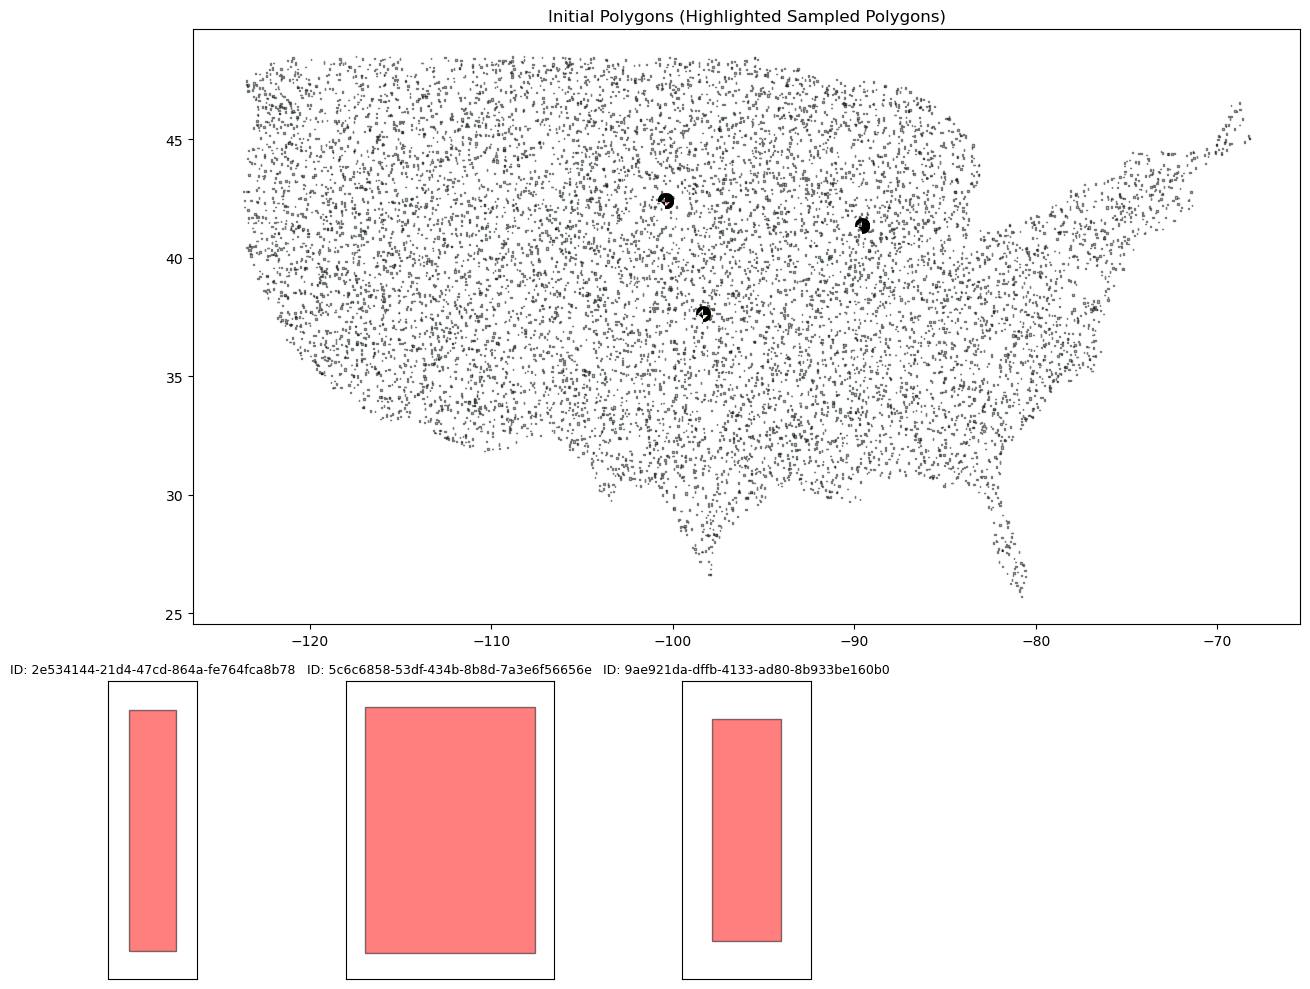

In [240]:
# Retrieve tables from PostgreSQL
df_prev = h.retrieve_pg_table(table_name='prev_blobs_wkt')
df_curr = h.retrieve_pg_table(table_name='curr_blobs_wkt')

# Ensure they are GeoDataFrames
df_prev = gpd.GeoDataFrame(df_prev, geometry='geometry', crs="EPSG:4326")
df_curr = gpd.GeoDataFrame(df_curr, geometry='geometry', crs="EPSG:4326")

# Retrieve matches table
table_name = 'matched_results'
postgresql_details['dbname'] = 'blob_matching'
conn = psycopg2.connect(**postgresql_details)
cur = conn.cursor()
cur.execute(f"SELECT prev_id, curr_id FROM {table_name};")
rows = cur.fetchall()
cur.close()
conn.close()

# Convert matches to DataFrame
matches = pd.DataFrame(rows, columns=["prev_id", "curr_id"])
print(f"Retrieved {len(matches)} records from {table_name}.")

# Find matching polygons
overlapping_a = df_prev[df_prev['id'].isin(matches['prev_id'])]
overlapping_b = df_curr[df_curr['id'].isin(matches['curr_id'])]

# Sample 5 overlapping polygons instead of 10
sample_size = min(5, len(overlapping_a))  # Limit to 5
sample_indices = random.sample(range(len(overlapping_a)), sample_size)
sample_a = overlapping_a.iloc[sample_indices]
sample_b = overlapping_b.iloc[sample_indices]

# Define figure layout with GridSpec (1 row for subplots instead of 2)
fig = plt.figure(figsize=(15, 10))
gs = gridspec.GridSpec(2, 5, height_ratios=[2, 1], width_ratios=[1, 1, 1, 1, 1])  # 2 rows: main + 1 row of 5 subplots

# --- Main Plot: Initial Polygons ---
ax_main = plt.subplot(gs[0, :])  # Top row spans all columns
df_prev.plot(ax=ax_main, color='lightblue', edgecolor='black', alpha=0.5, label="Previous", zorder=1)
df_curr.plot(ax=ax_main, color='lightgreen', edgecolor='black', alpha=0.5, label="Current", zorder=1)

# Overlay all sampled polygons with a **thin dashed outline**
sample_a.plot(ax=ax_main, color='none', edgecolor='yellow', linewidth=1, linestyle='dashed', zorder=3)
sample_b.plot(ax=ax_main, color='none', edgecolor='magenta', linewidth=1, linestyle='dashed', zorder=3)

# **Make the Grid Spec polygons stand out (increase linewidth selectively)**
highlighted_a = sample_a
highlighted_b = sample_b

highlighted_a.plot(ax=ax_main, color='none', edgecolor='black', linewidth=10, linestyle='solid', zorder=4)
highlighted_b.plot(ax=ax_main, color='none', edgecolor='black', linewidth=10, linestyle='solid', zorder=4)

ax_main.set_title("Initial Polygons (Highlighted Sampled Polygons)")

# --- Zoomed-in Subplots (Single row of 5 subplots) ---
for i, (idx, row) in enumerate(sample_a.iterrows()):
    ax = plt.subplot(gs[1, i])  # Now only 1 row (row index `1`)
    subset_a = sample_a.iloc[[i]]
    subset_b = sample_b.iloc[[i]]

    # Plot zoomed-in view
    subset_a.plot(ax=ax, color="red", edgecolor="black", alpha=0.5)
    subset_b.plot(ax=ax, color="orange", edgecolor="black", alpha=0.5)

    # Adjust zoom
    bounds = subset_a.geometry.bounds.values[0]  # Get bounding box
    buffer = 0.01  # Add a small margin for better visualization
    ax.set_xlim(bounds[0] - buffer, bounds[2] + buffer)
    ax.set_ylim(bounds[1] - buffer, bounds[3] + buffer)

    # Add ID as a title
    ax.set_title(f"ID: {row['id']}", fontsize=9)
    ax.set_xticks([])  # Remove x-axis labels
    ax.set_yticks([])  # Remove y-axis labels

# Adjust layout and show
plt.tight_layout()

# plt.savefig('figs/overlapping_polygons_map.pdf', bbox_inches='tight')
# plt.savefig('figs/overlapping_polygons_map.png', bbox_inches='tight')

plt.show()

Retrieved 1000 records from prev_blobs_wkt.
Function `retrieve_pg_table` executed in 0.0341 sec, CPU: 29.00%, Memory: 70.73MB
Retrieved 1000 records from curr_blobs_wkt.
Function `retrieve_pg_table` executed in 0.0120 sec, CPU: 90.00%, Memory: 14.97MB
Retrieved 12 records from matched_results.


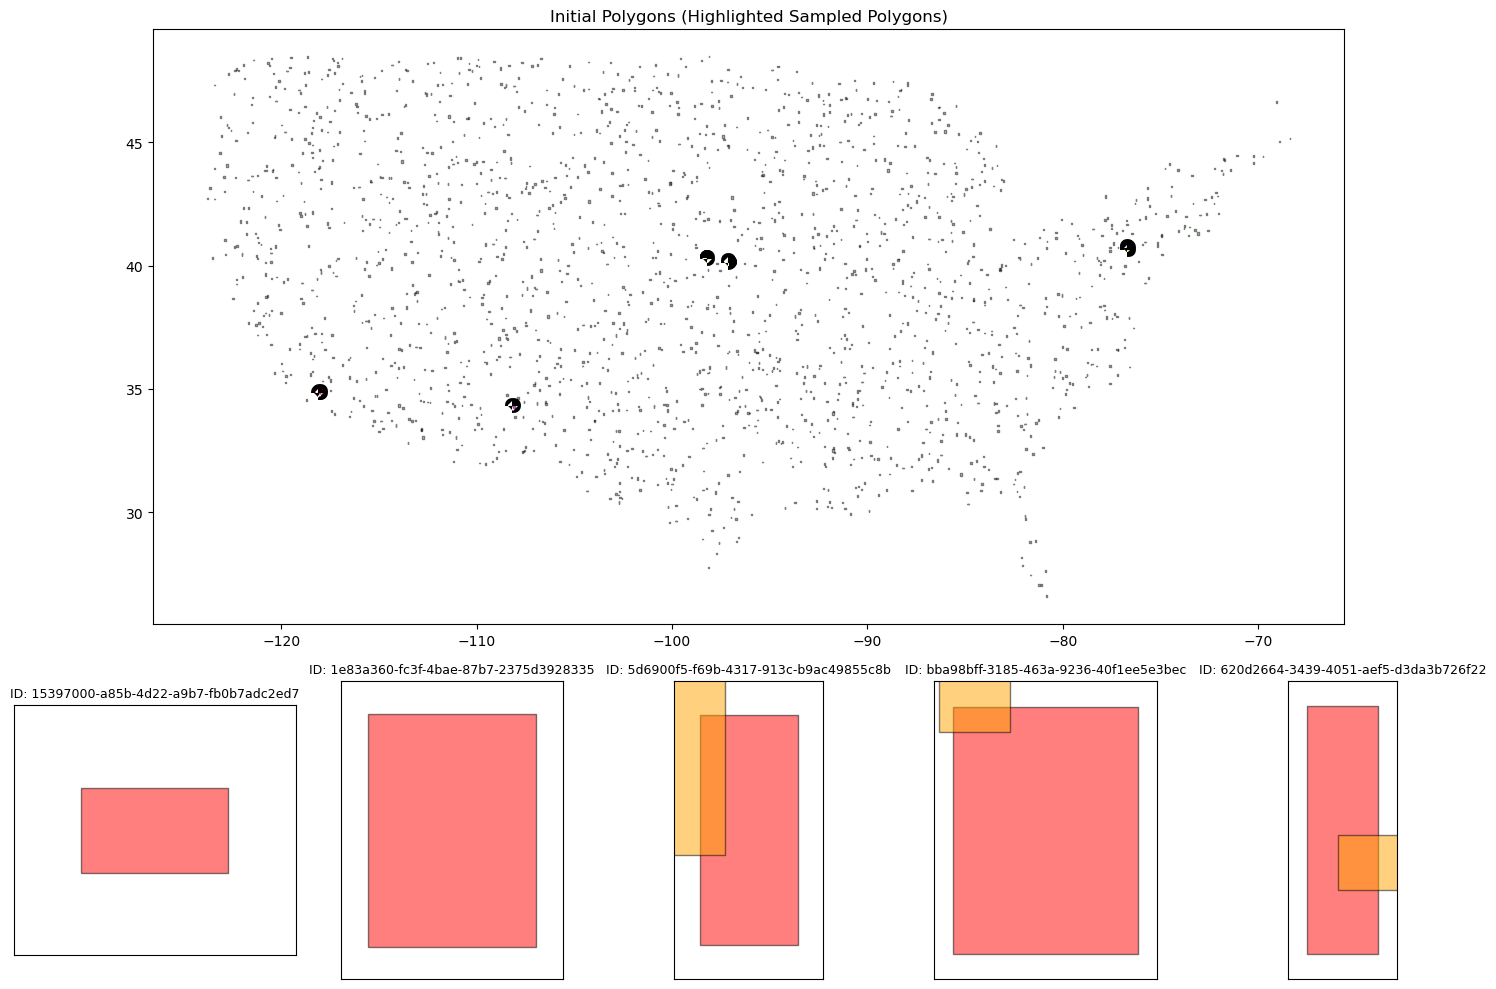

In [79]:
# Retrieve tables from PostgreSQL
df_prev = h.retrieve_pg_table(table_name='prev_blobs_wkt')
df_curr = h.retrieve_pg_table(table_name='curr_blobs_wkt')

# Ensure they are GeoDataFrames
df_prev = gpd.GeoDataFrame(df_prev, geometry='geometry', crs="EPSG:4326")
df_curr = gpd.GeoDataFrame(df_curr, geometry='geometry', crs="EPSG:4326")

# Retrieve matches table
table_name = 'matched_results'
postgresql_details['dbname'] = 'blob_matching'
conn = psycopg2.connect(**postgresql_details)
cur = conn.cursor()
cur.execute(f"SELECT prev_id, curr_id FROM {table_name};")
rows = cur.fetchall()
cur.close()
conn.close()

# Convert matches to DataFrame
matches = pd.DataFrame(rows, columns=["prev_id", "curr_id"])
print(f"Retrieved {len(matches)} records from {table_name}.")

# Find matching polygons
overlapping_a = df_prev[df_prev['id'].isin(matches['prev_id'])]
overlapping_b = df_curr[df_curr['id'].isin(matches['curr_id'])]

# Sample 5 overlapping polygons instead of 10
sample_size = min(5, len(overlapping_a))  # Limit to 5
sample_indices = random.sample(range(len(overlapping_a)), sample_size)
sample_a = overlapping_a.iloc[sample_indices]
sample_b = overlapping_b.iloc[sample_indices]

# Define figure layout with GridSpec (1 row for subplots instead of 2)
fig = plt.figure(figsize=(15, 10))
gs = gridspec.GridSpec(2, 5, height_ratios=[2, 1], width_ratios=[1, 1, 1, 1, 1])  # 2 rows: main + 1 row of 5 subplots

# --- Main Plot: Initial Polygons ---
ax_main = plt.subplot(gs[0, :])  # Top row spans all columns
df_prev.plot(ax=ax_main, color='lightblue', edgecolor='black', alpha=0.5, label="Previous", zorder=1)
df_curr.plot(ax=ax_main, color='lightgreen', edgecolor='black', alpha=0.5, label="Current", zorder=1)

# Overlay all sampled polygons with a **thin dashed outline**
sample_a.plot(ax=ax_main, color='none', edgecolor='yellow', linewidth=1, linestyle='dashed', zorder=3)
sample_b.plot(ax=ax_main, color='none', edgecolor='magenta', linewidth=1, linestyle='dashed', zorder=3)

# **Make the Grid Spec polygons stand out (increase linewidth selectively)**
highlighted_a = sample_a
highlighted_b = sample_b

highlighted_a.plot(ax=ax_main, color='none', edgecolor='black', linewidth=10, linestyle='solid', zorder=4)
highlighted_b.plot(ax=ax_main, color='none', edgecolor='black', linewidth=10, linestyle='solid', zorder=4)

ax_main.set_title("Initial Polygons (Highlighted Sampled Polygons)")

# --- Zoomed-in Subplots (Single row of 5 subplots) ---
for i, (idx, row) in enumerate(sample_a.iterrows()):
    ax = plt.subplot(gs[1, i])  # Now only 1 row (row index `1`)
    subset_a = sample_a.iloc[[i]]
    subset_b = sample_b.iloc[[i]]

    # Plot zoomed-in view
    subset_a.plot(ax=ax, color="red", edgecolor="black", alpha=0.5)
    subset_b.plot(ax=ax, color="orange", edgecolor="black", alpha=0.5)

    # Adjust zoom
    bounds = subset_a.geometry.bounds.values[0]  # Get bounding box
    buffer = 0.01  # Add a small margin for better visualization
    ax.set_xlim(bounds[0] - buffer, bounds[2] + buffer)
    ax.set_ylim(bounds[1] - buffer, bounds[3] + buffer)

    # Add ID as a title
    ax.set_title(f"ID: {row['id']}", fontsize=9)
    ax.set_xticks([])  # Remove x-axis labels
    ax.set_yticks([])  # Remove y-axis labels

# Adjust layout and show
plt.tight_layout()

plt.savefig('figs/overlapping_polygons_map.pdf', bbox_inches='tight')
plt.savefig('figs/overlapping_polygons_map.png', bbox_inches='tight')

plt.show()

## 2. Optimized Approach

Having demonstrated a reasonable if not optimized way of matching polygons, we will now make use of geospatial-native tools to hopefully match polygons much more quickly.

My proposed workflow centers around `DuckDB` and `H3` along with the `.parquet` format to efficiently store, retrieve, and process geospatial data. We will use `Apache Iceberg` as a layer over the parquet file as it allows for more robust table handling.

1. Prepare GeodataFrames with H3 Polyfill and parent hexagons at lower resolution.
   * Save as an Iceberg table.

2. Use DuckDB and the H3 extension to execute spatial SQL queries to find overlapping polygons with H3-based joins.

3. Save matching polygon IDs to a new Iceberg table.

4. Visualize the results.

### 2.1. Add H3 data to the blobs

H3 is a modern and efficient geospatial index paradigm that divides the world into nested hexagons.

In [902]:
prev_month_blobs.head()

,geometry,id,geohash
0,"POLYGON ((-81.10504 26.01885, -81.04984 26.018...",6cc95c8a-cbaf-4993-a9ff-4e890c7e45f0,dhwk5h
1,"POLYGON ((-80.91675 26.04190, -80.86358 26.041...",a0fbead2-d8dc-4e05-b364-ab89d020fbfb,dhwkpq
2,"POLYGON ((-80.73525 26.20304, -80.71903 26.203...",b4c64915-35eb-4d74-a211-ce41ad8f21f8,dhwt55
3,"POLYGON ((-80.86288 26.17613, -80.79088 26.176...",d03d2784-ff88-4ed6-b93c-2b52a8a7ecc3,dhwt0s
4,"POLYGON ((-81.28584 26.19397, -81.21442 26.193...",0ce2ca44-0727-4364-978b-da23cd9cd784,dhwjpj


In [903]:
def compute_h3_indices(geometry, centroid_res=6, polyfill_res=9):
    """
    Compute H3 indices for a polygon:
    - Single H3 index based on centroid
    - Full polygon coverage with H3 polyfill at high resolution
    """
    centroid = geometry.centroid
    h3_centroid = h3.geo_to_h3(centroid.y, centroid.x, centroid_res)

    # Full coverage using polyfill
    h3_polyfill = list(h3.polyfill(geometry.__geo_interface__, polyfill_res))

    return h3_centroid, h3_polyfill

In [ ]:
test_prev = prev_month_blobs.copy()
test_curr = curr_month_blobs.copy()

for gdf in [test_prev, test_curr]:
    gdf['h3_centroid'] = gdf['geometry'].apply(lambda geom: compute_h3_indices(geom, 6, 9))

In [899]:
print(type(prev_month_blobs))
prev_month_blobs.head(3)
# prev_month_blobs = gpd.read_parquet('data/prev_month_blobs.parquet')
# curr_month_blobs = gpd.read_parquet('data/curr_month_blobs.parquet')

<class 'geopandas.geodataframe.GeoDataFrame'>


,geometry,id,geohash
0,"POLYGON ((-81.10504 26.01885, -81.04984 26.018...",6cc95c8a-cbaf-4993-a9ff-4e890c7e45f0,dhwk5h
1,"POLYGON ((-80.91675 26.04190, -80.86358 26.041...",a0fbead2-d8dc-4e05-b364-ab89d020fbfb,dhwkpq
2,"POLYGON ((-80.73525 26.20304, -80.71903 26.203...",b4c64915-35eb-4d74-a211-ce41ad8f21f8,dhwt55


# Notes on original process

geohash polygon into a larger region
match blobs using multiprocessing (mp.Process) and geopandas
find blobs from previous month that do not have a match

# 1 imports and setup

```python
import os, sys, traceback
import argparse
import cv2
import time
import numpy as np
import pandas as pd
import geopandas as gpd
from skimage import io, color, measure
from tqdm import tqdm
from shapely import wkt
from shapely.geometry import Point, Polygon
from shapely.validation import make_valid
import PIL
from PIL import Image, ImageDraw, ImageEnhance
import uuid
import multiprocessing as mp
from datetime import datetime
from sqlalchemy import or_
from sqlmodel import SQLModel, Session, create_engine, select
from pathlib import Path
```

## Key takeaways
- Uses Pandas and GeoPandas for data processing.
- Uses Shapely for geospatial geometry operations.
- Uses multiprocessing (mp) to parallelize the blob-matching process.
- Uses SQLAlchemy and SQLModel for database operations.

# 2 High-level script overview
The script is designed to match blobs (spatial objects) between two months and classify them into different business categories.

General Workflow
1. Fetch blobs from the previous and current months.
1. Convert the region of interest (state, city, county, or geohash) into a list of geohashes.
1. Parallelized Matching Process:
1. Process multiple geohashes at once using multiprocessing.
1. Find corresponding blobs from previous months for each geohash.
1. Classify blobs based on construction stage progression.
1. Identify blobs that are missing in the current month and "impute" them.
1. Save results into the database.

# 3 Blob classification logic

# 4 Blob matching

- Matches blobs between months using polygon intersections.
- Uses Shapely to validate geometries and check for overlaps.
- Returns matched blob IDs.

## Multiprocessing Optimization
The script parallelizes blob matching by:
- Uses multiprocessing (mp.Process) to divide the dataset into smaller batches.
- Each batch of blobs is processed in parallel.
- Reduces runtime compared to a single-threaded approach.

# 5 Handling unmatched blobs
- Finds blobs from the previous month that do not have a match in the current month.
- These blobs are "imputed", meaning they are carried over into the new month.

# 6 Main class to orchestrate process
- Loads previous and current month blobs.
- Converts input regions (state, city, county) into geohashes.

# Summary
- Parallel processing is used to match blobs.
- Blobs are classified based on construction stages.
- Unmatched blobs are imputed for continuity.
- The script writes results to a database.